In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = "skin-cancer-data"

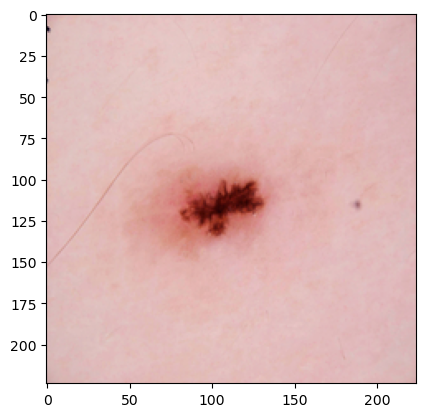

In [3]:
import matplotlib.image as mpimg
test_image = "skin-cancer-data/benign/1.jpg"
img = mpimg.imread(test_image)
plt.imshow(img)

In [4]:
# define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3297 files belonging to 2 classes.
Using 2638 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=132,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 3297 files belonging to 2 classes.
Using 659 files for validation.


In [7]:
class_names = train_ds.class_names
class_names

['benign', 'malignant']

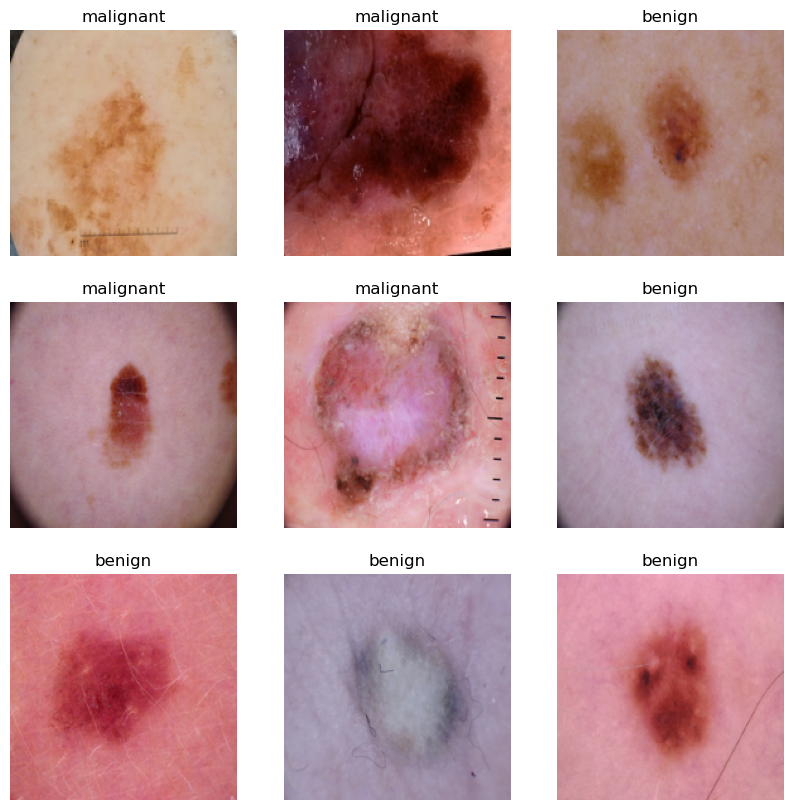

In [8]:
# Here are the first nine images from training dataset
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [9]:
# manually iterate over the dataset and retrieve batches of images
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [10]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [11]:
# Standardize values to be in the [0, 1] RGB channel range by using tf.keras.Rescalling
normalization_layers = layers.Rescaling(1./255)

In [12]:
# create a basic keras model

num_classes = len(class_names)

model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [13]:
# Compile the model

model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=["accuracy"])

In [14]:
# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [15]:
# Train the model for 10 epochs

epochs = 10
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/10
83/83 [==============================] - 143s 1s/step - loss: 0.5499 - accuracy: 0.7225 - val_loss: 0.4936 - val_accuracy: 0.7481
Epoch 2/10
83/83 [==============================] - 99s 1s/step - loss: 0.4145 - accuracy: 0.7923 - val_loss: 0.4184 - val_accuracy: 0.7921
Epoch 3/10
83/83 [==============================] - 92s 1s/step - loss: 0.4208 - accuracy: 0.7908 - val_loss: 0.4334 - val_accuracy: 0.7830
Epoch 4/10
83/83 [==============================] - 92s 1s/step - loss: 0.3514 - accuracy: 0.8287 - val_loss: 0.4156 - val_accuracy: 0.8103
Epoch 5/10
83/83 [==============================] - 92s 1s/step - loss: 0.3524 - accuracy: 0.8309 - val_loss: 0.3901 - val_accuracy: 0.8118
Epoch 6/10
83/83 [==============================] - 99s 1s/step - loss: 0.3150 - accuracy: 0.8469 - val_loss: 0.3769 - val_accuracy: 0.8179
Epoch 7/10
83/83 [==============================] - 100s 1s/step - loss: 0.3246 - accuracy: 0.8495 - val_loss: 0.3851 - val_accuracy: 0.8209
Epoch 8/10
83/83 [

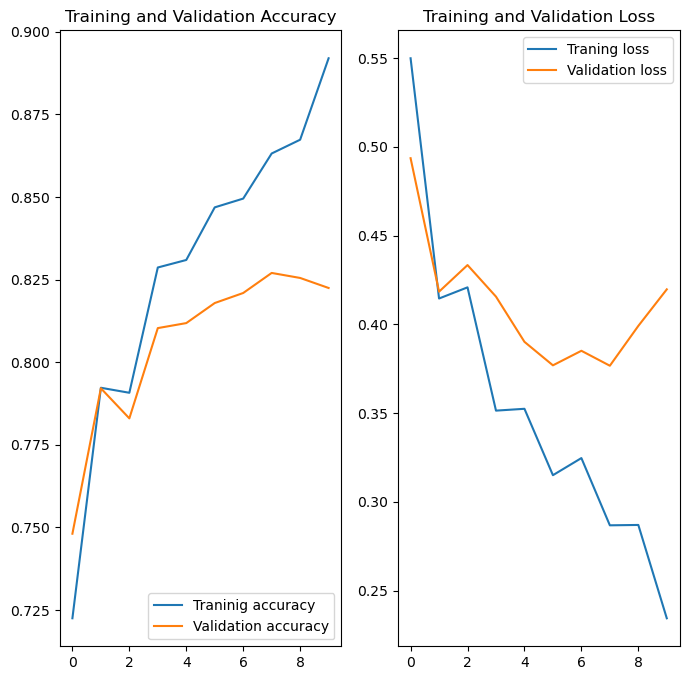

In [16]:
# visualize training results by creatting plots for loss and accuracy on the training and validation sets

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Traninig accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Traning loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [17]:
# Reduce overfitting though data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                     input_shape=(img_height, 
                                 img_width,
                                 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

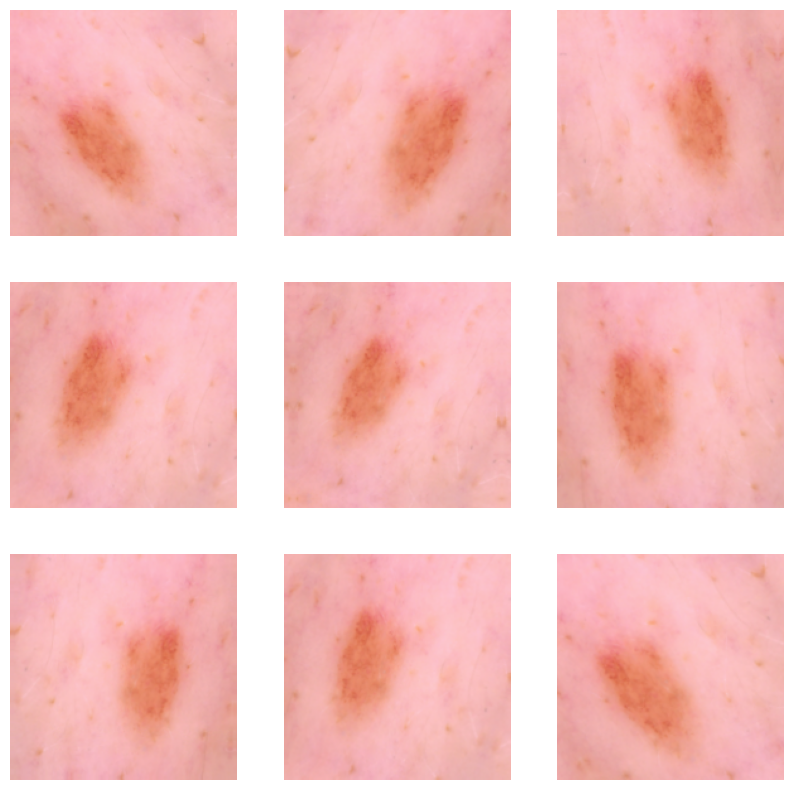

In [18]:
# visualize a few augmentade examples by applying data augmentation to the same image several times
plt.figure(figsize=(10,10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

In [19]:
# introduce Dropout to the network to help reduce overfitting

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64,3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name='outputs')
])

In [20]:
# compile and train the model

model.compile(optimizer='adam',
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [22]:
epochs = 15

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=epochs
)

Epoch 1/15
83/83 [==============================] - 117s 1s/step - loss: 0.5815 - accuracy: 0.6804 - val_loss: 0.4681 - val_accuracy: 0.7572
Epoch 2/15
83/83 [==============================] - 114s 1s/step - loss: 0.4364 - accuracy: 0.7828 - val_loss: 0.3965 - val_accuracy: 0.7997
Epoch 3/15
83/83 [==============================] - 115s 1s/step - loss: 0.3949 - accuracy: 0.8063 - val_loss: 0.4017 - val_accuracy: 0.7951
Epoch 4/15
83/83 [==============================] - 110s 1s/step - loss: 0.3832 - accuracy: 0.8127 - val_loss: 0.4184 - val_accuracy: 0.7876
Epoch 5/15
83/83 [==============================] - 111s 1s/step - loss: 0.3782 - accuracy: 0.8196 - val_loss: 0.3842 - val_accuracy: 0.8058
Epoch 6/15
83/83 [==============================] - 110s 1s/step - loss: 0.3429 - accuracy: 0.8370 - val_loss: 0.3749 - val_accuracy: 0.8027
Epoch 7/15
83/83 [==============================] - 110s 1s/step - loss: 0.3507 - accuracy: 0.8199 - val_loss: 0.3960 - val_accuracy: 0.8194
Epoch 8/15
83

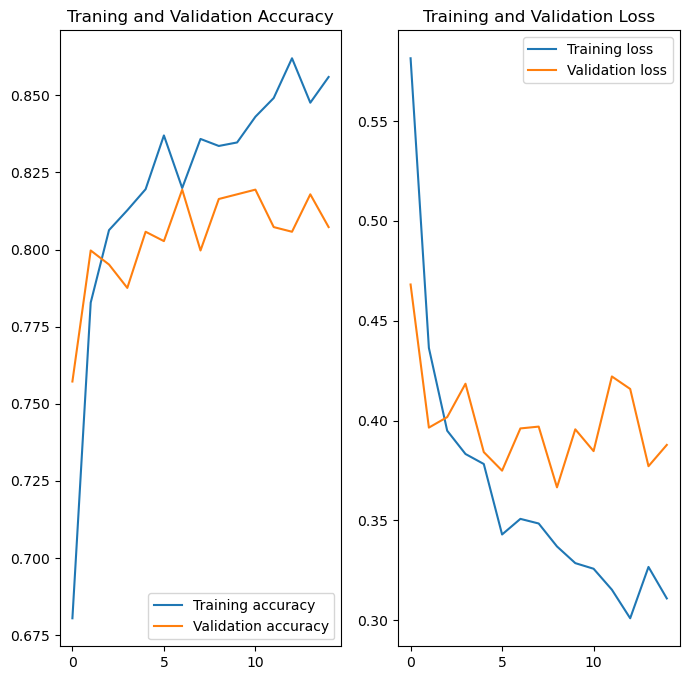

In [23]:
# Visualizing the training results

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training accuracy")
plt.plot(epochs_range, val_acc, label="Validation accuracy")
plt.legend(loc="lower right")
plt.title("Traning and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training loss")
plt.plot(epochs_range, val_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [24]:
# predict on new data
img = tf.keras.utils.load_img(
    "skin-cancer-data/bening1.jpg", target_size= (img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # create a batch
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 439ms/step
This image most likely belongs to benign with a 98.91 percent confidence.


In [25]:
# img2 = tf.keras.utils.load_img(
#     "skin-cancer-data/malig.jpg", target_size = (img_height, img_width)
# )
# img_array1 = tf.keras.utils.img_to_array(img2)
# img_array1 = tf.expand_dims(img_array1, 0) # create a batch
# predictions = model.predict(img_array1)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# ) 

In [26]:
# # convert the model to tensorflow lite

# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # save the model
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)

In [27]:
# # run the tensorflow lite model

# TF_MODEL_FILE_PATH = 'model.tflite'
# interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [28]:
# # Print signatures from the converted model to get the names of the inputs and outputs

# interpreter.get_signature_list()

In [29]:
# # test the loaded model

# classify_lite = interpreter.get_signature_runner('serving_default')
# classify_lite

In [30]:
# # make predictions using the tensorflow lite model

# predictions_lite = classify_lite(sequential_1_input = img_array)['outputs']
# score_lite = tf.nn.softmax(predictions_lite)

In [31]:
# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
# )

In [32]:
import os
import json
import requests
import tempfile

In [33]:
MODEL_DIR = "ML/models/skin_cancer_model"
version = '1'
export_path = os.path.join(MODEL_DIR, str(version))

# save the model
model.save(export_path, save_format='tf')
print("\nextport_path = {}".format(export_path))
!dir {export_path}

INFO:tensorflow:Assets written to: ML/models/skin_cancer_model\1\assets


INFO:tensorflow:Assets written to: ML/models/skin_cancer_model\1\assets



extport_path = ML/models/skin_cancer_model\1


Invalid switch - "models".


In [34]:
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['sequential_1_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 180, 180, 3)
        name: serving_default_sequential_1_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['outputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 2)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict
The MetaGraph with tag set ['serve'] contains the following ops: {'Identity', 'MergeV2Checkpoints', 'Statefu